# Generating (CMIP6) future droughts

This notebook is used to predict future discharge values for the Loire river at Blois. For these prediction, different climate scenarios are used: SSP126, SSP2455 and SSP585. These discharge values are then analysed using the drought analyser (Drought_analyser.ipynb) to assess the difference between past and future. 

### 1. Importing general python modules

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import seaborn as sns

#niceties
from rich import print

# Needed
from ipywidgets import IntProgress
from IPython.display import display
from scipy.stats import qmc
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# import drought analyser function
%run Drought_analyser.ipynb

### 2. Defining experiment data and paths 

In this chapter all the variables are defined for the chosen basin. Also the loading and generating path are defined for the forcings and model.

In [4]:
# name of the catchment
basin_name = "FR003882"

# defining dates for calibration
historical_start_date = "1941-01-01"
historical_end_date = "2014-12-31"
future_start_data = "2026-01-01"
future_end_data = "2099-12-31"

# defining path for catchment shape file
station_shp = Path.home() / "BEP-Loire" / "book" / "model_loire" / "estreams_cb_FR003882.shp"

# defining destination path for ERA5 data
forcing_path_CMIP = Path.home() / "forcing" / "loire_river" / "CMIP"
forcing_path_CMIP.mkdir(exist_ok=True)

# model HBV destination path
model_path_HBV = Path.home() / "tmp" / "HBV_model" / "CMIP"
model_path_HBV.mkdir(exist_ok=True)

gdf = gpd.read_file("estreams_cb_FR003882.shp")
gdf = gdf.to_crs(epsg=2154)
gdf["area_km2"] = gdf.geometry.area / 1e6  
basin_area = gdf["area_km2"].sum()

### 3. Load generated CMIP forcings

The CMIP6 data can be generated using CMIP_forcing. If the is already generated, it can be loaded using option 2.

In [5]:
# Option one: Generate CMIP data
#cmip_dataset =  {
#    'project': 'CMIP6',
#    'activity': 'ScenarioMIP',
#    'exp': 'ssp126',
#    'mip': 'day',
#    'dataset': 'MPI-ESM1-2-HR',
#    'ensemble': 'r1i1p1f1',
#    'institute': 'DKRZ',
#    'grid': 'gn'
#}

#cmip_historical =  {
#    'project': 'CMIP6',
#    'exp': 'historical',
#    'dataset': 'MPI-ESM1-2-HR',
#    "ensemble": 'r1i1p1f1',
#    'grid': 'gn'
#}

#CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=cmip_dataset,
#    start_time=future_start_data+"T00:00:00Z",
#    end_time=future_end_data+"T00:00:00Z",
#    shape=station_shp,
#    directory=forcing_path_CMIP,
#)

In [6]:
# Option two: load generated data
# Load historical data
historic_location = forcing_path_CMIP / "Historical" / "work" / "diagnostic" / "script" 
HIST = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=historic_location)

# Load SSP126 data
ssp126_location = forcing_path_CMIP / "SSP126_2699" / "work" / "diagnostic" / "script" 
SSP126 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp126_location)

# Load SSP245 data
ssp245_location = forcing_path_CMIP / "SSP245_2699" / "work" / "diagnostic" / "script" 
SSP245 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp245_location)

# Load SSP585 data
ssp585_location = forcing_path_CMIP / "SSP585_2699" / "work" / "diagnostic" / "script" 
SSP585 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp585_location)

### 4. Setting up the model (HBV)

The parameters for the HBV are calibrated in HBV_calibration.ipynb. These calibrated parameters are defined below. The starting values for model stores are manually adjust using a 'spin-up' method.

In [7]:
# Good parameters distribution calibration (N = 2000)
params = [
    6.382012946132834,
    0.6365395937132804,
    366.6921134386536,
    3.275414443053375,
    0.22241595560479888,
    9.260634181675487,
    0.09034248156803193,
    0.0003441943533997508,
    0.026098858621656
]

# Starting values for model storages
#                Si,    Su,  Sf,    Ss,  Sp
s_0 = np.array([5.3, 249.8, 2.4, 372.5, 2.9])

### 5. Running the model

The HBV model runs all generated scenarios at once (Historical, SSP126, SSP245 and SSP585).

In [8]:
forcing_list = [HIST, SSP126, SSP245, SSP585]
output = []
years = []

for forcings in forcing_list:
    model = ewatercycle.models.HBV(forcing=forcings)
    config_file, _ = model.setup(
        parameters=params, 
        initial_storage=s_0,
        cfg_dir = model_path_HBV,
    )

    model.initialize(config_file)

    Q_m = []
    time = []
    
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
        
    output.append(Q_m)
    years.append(time)
    
    del Q_m, time
    model.finalize()

### 6. Get results

The discharge output for every scenario is stored into dataframe and then converted from mm/d into m3/s data.

In [9]:
# Load output data
historical_output = pd.Series(data=output[0], name="Historical", index=years[0])["1942-01-01":]
SSP126_output = pd.Series(data=output[1], name="SSP126", index=years[1])["2027-01-01":]
SSP245_output = pd.Series(data=output[2], name="SSP245", index=years[2])["2027-01-01":]
SSP585_output = pd.Series(data=output[3], name="SSP585", index=years[3])["2027-01-01":]

q_data = pd.read_csv("FR003882_streamflow_m3s.csv", index_col='date', parse_dates=True)["FR003882"]
q_data_4214 = q_data['1942-01-01':'2014-12-31']

# Convert mm/d to m3/s
factor = basin_area / 86.4
historical_output *= factor
SSP126_output *= factor
SSP245_output *= factor
SSP585_output *= factor

### 7. Drought analyser

Droughts for every scenario are analysed using drought_analyser function from Drought_analyser.ipynb notebook. The droughts and the relation between duration and deficit are plotted in the graph below.

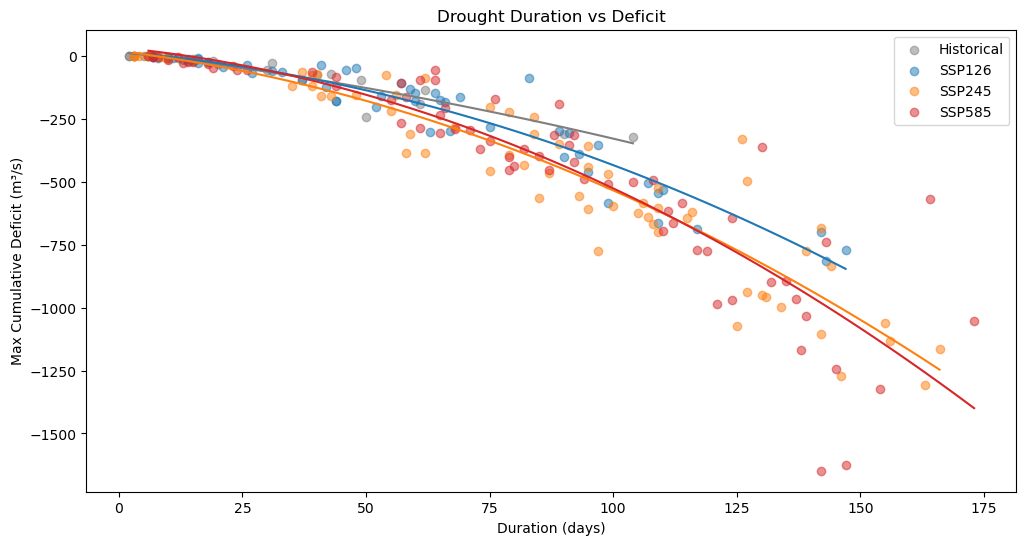

In [10]:
# Run drought analyser
historical_droughts = drought_analyser(historical_output, '', 66.5)
SSP126_droughts = drought_analyser(SSP126_output, '', 66.5)
SSP245_droughts = drought_analyser(SSP245_output, '', 66.5)
SSP585_droughts = drought_analyser(SSP585_output, '', 66.5)

xh, yh = historical_droughts["Duration (days)"], historical_droughts["Max Cumulative Deficit (m3/s)"]
x1, y1 = SSP126_droughts["Duration (days)"], SSP126_droughts["Max Cumulative Deficit (m3/s)"]
x2, y2 = SSP245_droughts["Duration (days)"], SSP245_droughts["Max Cumulative Deficit (m3/s)"]
x5, y5 = SSP585_droughts["Duration (days)"], SSP585_droughts["Max Cumulative Deficit (m3/s)"]


# Functie voor polyfit en plot
def plot_droughts(x, y, color, label):
    coeffs = np.polyfit(x, y, 2)
    poly_func = np.poly1d(coeffs)
    
    x_smooth = np.linspace(x.min(), x.max(), 100)
    y_smooth = poly_func(x_smooth)
    
    plt.scatter(x, y, color=color, alpha=0.5, label=label)
    plt.plot(x_smooth, y_smooth, color=color)

plt.figure(figsize=(12, 6))

# Data plotten met behulp van de functie
plot_droughts(xh, yh, "#7f7f7f", "Historical")
plot_droughts(x1, y1, "#1f77b4", "SSP126")
plot_droughts(x2, y2, "#ff7f0e", "SSP245")
plot_droughts(x5, y5, "#d62728", "SSP585")

plt.title('Drought Duration vs Deficit')
plt.xlabel('Duration (days)')
plt.ylabel('Max Cumulative Deficit (m³/s)')
plt.legend()
plt.show()

### 8. Distribution

The distribution for duration and deficit is also plotted to gain a better understanding of the differences between each scenario. For this, Seaborn's kdeplot is used to plot these distributions.

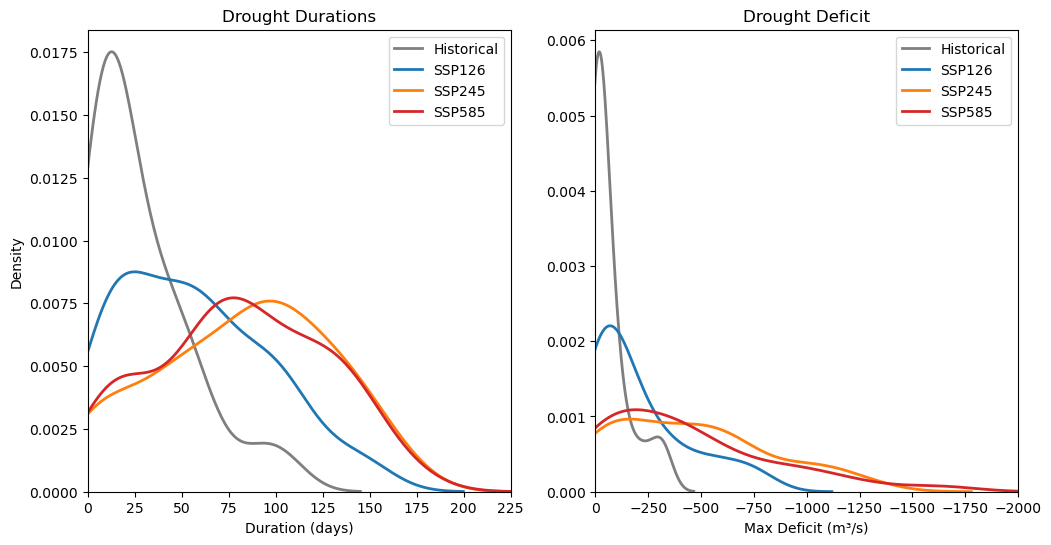

In [11]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot 1: Duration
plt.subplot(1, 2, 1)
sns.kdeplot(xh, label='Historical', color="#7f7f7f", linewidth=2)
sns.kdeplot(x1, label='SSP126', color="#1f77b4", linewidth=2)
sns.kdeplot(x2, label='SSP245', color="#ff7f0e", linewidth=2)
sns.kdeplot(x5, label='SSP585', color="#d62728", linewidth=2)
plt.title('Drought Durations')
plt.xlabel('Duration (days)')
plt.xlim(0, 225)
plt.legend()

# Plot 2: Deficit
plt.subplot(1, 2, 2)
sns.kdeplot(yh, label='Historical', color="#7f7f7f", linewidth=2)
sns.kdeplot(y1, label='SSP126', color="#1f77b4", linewidth=2)
sns.kdeplot(y2, label='SSP245', color="#ff7f0e", linewidth=2)
sns.kdeplot(y5, label='SSP585', color="#d62728", linewidth=2)
plt.title('Drought Deficit')
plt.xlabel('Max Deficit (m³/s)')
plt.ylabel('')
plt.xlim(-2000, 0)
plt.gca().invert_xaxis()
plt.legend()

### 9. Cumulative distribution

The fitted line in Chapter 7 and the distribution did not give the best results to visually analyse the scenarios. For this, the cumulative distribution is used as it better displays the differences.

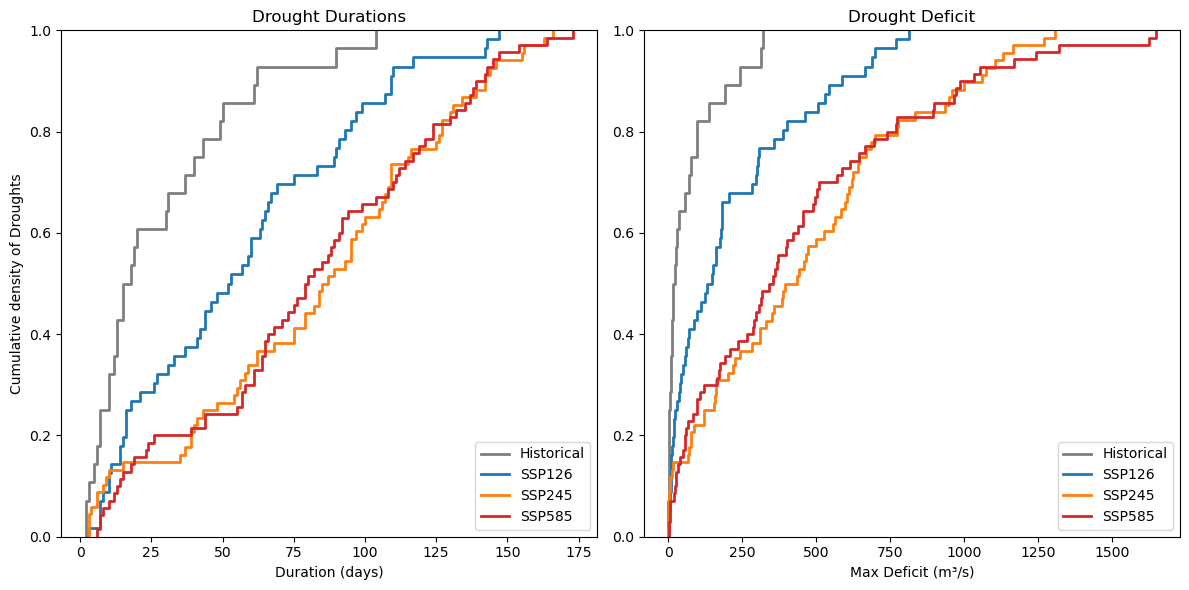

In [12]:
plt.figure(figsize=(12, 6))

# Plot 1: Duration
plt.subplot(1, 2, 1)
sns.ecdfplot(xh, label='Historical', color="#7f7f7f", linewidth=2)
sns.ecdfplot(x1, label='SSP126', color="#1f77b4", linewidth=2)
sns.ecdfplot(x2, label='SSP245', color="#ff7f0e", linewidth=2)
sns.ecdfplot(x5, label='SSP585', color="#d62728", linewidth=2)
plt.title('Drought Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Cumulative density of Droughts')
plt.legend(loc='lower right')

# Plot 2: Deficit
plt.subplot(1, 2, 2)
sns.ecdfplot(yh*-1, label='Historical', color="#7f7f7f", linewidth=2)
sns.ecdfplot(y1*-1, label='SSP126', color="#1f77b4", linewidth=2)
sns.ecdfplot(y2*-1, label='SSP245', color="#ff7f0e", linewidth=2)
sns.ecdfplot(y5*-1, label='SSP585', color="#d62728", linewidth=2)
plt.title('Drought Deficit')
plt.xlabel('Max Deficit (m³/s)')
plt.ylabel('')
#plt.gca().invert_axis()
plt.legend()

plt.tight_layout()
plt.show()

### 10. Return period

The visual analysis is done in Chapter 9, yet to give a quantitative conclusion on the differences, the return period is used. 
For the return period of droughts the following functions are used:

T_D = N / (n(1 - F_D(d)))

T_S = N / (n(1 - F_S(s)))

- T_D = return period for duration
- T_S = return period for severity
- N = length of the experiment period
- n = amount of occurences
- F_D(d) = cumulative distribution for drought duration (displayed in chapter 9, left plot)
- F_S(s) = cumulative distribution for drought severity (displayed in chapter 9, right plot)

A correction factor CF=2.2 is applied for drought severity as it showed bias during validation on the period 1990-2014. This correction factor was manually defined in chapter 11.

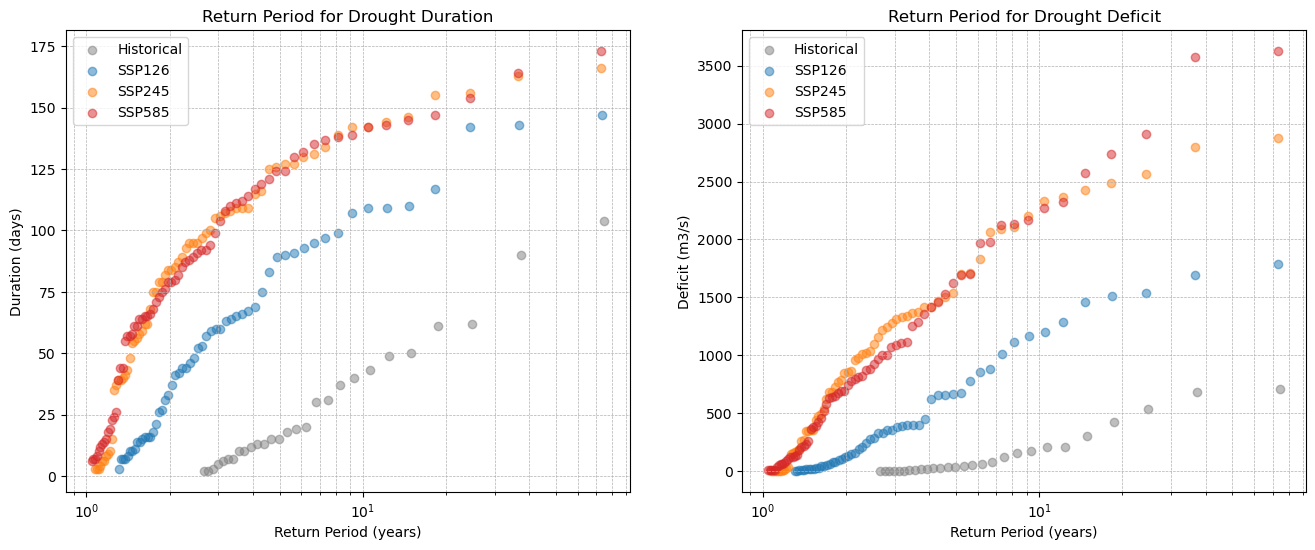

In [15]:
def plot_return_period(data, years, color, label):
    sorted_data = np.sort(data)
    N = years
    n = len(sorted_data)

    # Emperical cumulative distribution
    F = np.arange(1, n + 1) / (n + 1)

    # Return Period
    return_period = N / (n * (1 - F))

    # Plot
    plt.scatter(return_period, sorted_data, color=color, alpha=0.5, label=label)

# Plot
plt.figure(figsize=(16, 6))

# Duration
plt.subplot(1, 2, 1)
plot_return_period(xh, 72, "#7f7f7f", "Historical")
plot_return_period(x1, 72, "#1f77b4", "SSP126")
plot_return_period(x2, 72, "#ff7f0e", "SSP245")
plot_return_period(x5, 72, "#d62728", "SSP585")

plt.xscale('log')
plt.title('Return Period for Drought Duration')
plt.xlabel('Return Period (years)')
plt.ylabel('Duration (days)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Duration
plt.subplot(1, 2, 2)
plot_return_period(yh*-2.2, 72, "#7f7f7f", "Historical")
plot_return_period(y1*-2.2, 72, "#1f77b4", "SSP126")
plot_return_period(y2*-2.2, 72, "#ff7f0e", "SSP245")
plot_return_period(y5*-2.2, 72, "#d62728", "SSP585")

plt.xscale('log')
plt.title('Return Period for Drought Deficit')
plt.xlabel('Return Period (years)')
plt.ylabel('Deficit (m3/s)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()


plt.show()

### 11. Determine correction factor

Based on the validation of CMIP6 historical discharge and observed discharge for the period 1990-2014, drought duration does not require a correction factor (CF). However, drought severity shows signification error. For this, a CF is created. The CF is determined by checking which factor fits best (the CF is adjusted untill the result is satisfactory, no algorithm is used to do this).

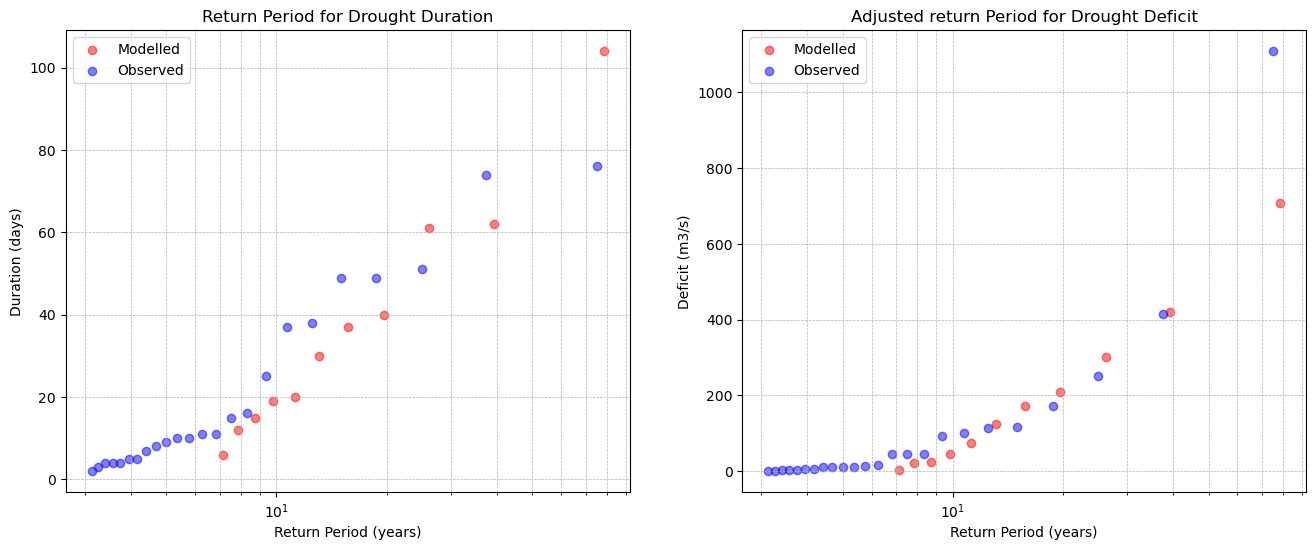

In [18]:
# Loading data for 1990-2014
historical_observations = pd.Series(data=output[0], name="Historical", index=years[0])["1990-01-01":]
historical_observations *= factor

cmip_output = pd.read_csv("FR003882_streamflow_m3s.csv", index_col='date', parse_dates=True)["FR003882"]
cmip_9014 = cmip_output['1990-01-01':'2014-12-31']

# Use drought analyser
historical_droughts = drought_analyser(historical_observations, '', 66.5)
cmip_droughts = drought_analyser(cmip_9014, '', 66.5)

xh, yh = historical_droughts["Duration (days)"], historical_droughts["Max Cumulative Deficit (m3/s)"]
xc, yc = cmip_droughts["Duration (days)"], cmip_droughts["Max Cumulative Deficit (m3/s)"]

# Plot the return periods for observed and cmip historical data
plt.figure(figsize=(16, 6))

# Duration
plt.subplot(1, 2, 1)
plot_return_period(xh, 72, "red", "Modelled")
plot_return_period(xc, 72, "blue", "Observed")

plt.xscale('log')
plt.title('Return Period for Drought Duration')
plt.xlabel('Return Period (years)')
plt.ylabel('Duration (days)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Duration
CF = 2.2
plt.subplot(1, 2, 2)
plot_return_period(-yh*CF, 72, "red", "Modelled")
plot_return_period(-yc, 72, "blue", "Observed")

plt.xscale('log')
plt.title('Adjusted return Period for Drought Deficit')
plt.xlabel('Return Period (years)')
plt.ylabel('Deficit (m3/s)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()